Reward modeling is necessary to guide the LLM to prioritize certain behaviors, so that it can generate responses that align with the objective.

In [1]:
import triton
import json
from datasets import load_dataset, DatasetDict
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments, Seq2SeqTrainingArguments
from peft import LoraConfig, TaskType
from transformers import TrainingArguments
from trl import RewardTrainer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

c:\Users\mahat\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset: synthetic-instruct-gptj-pairwise 
This is a synthetic data set that is designed for training and evaluating instruction-following models. It includes pairs of prompts and responses, with one reponse is prefered over the other (preference dataset). This is useful to distinguish between good and bad response- for reinforcement learning with human feedback (RLHF) tasks

In [3]:
dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise")

print(dataset)
print(dataset["train"][0].keys())
print(f"Prompt: {dataset["train"][0]["prompt"]}")
print(f"Chosen Response: {dataset["train"][0]["chosen"]}")
print(f"Rejected Response: {dataset["train"][0]["rejected"]}")

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 33143
    })
})
dict_keys(['prompt', 'chosen', 'rejected'])
Prompt: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.
Chosen Response: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. 

In [4]:
model_id = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_id, use_fast=True)
model = GPT2ForSequenceClassification.from_pretrained(model_id, num_labels=1) # num_labels = 1 because we want to output a single numerical score denoting the quality of the response

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# For GPT-2, set the pad_token to eos_token
tokenizer.pad_token = tokenizer.eos_token 
model.config.pad_token_id = model.config.eos_token_id

max_len = 1024

In [6]:
def format_dataset(dataset, response_type="chosen"):
    output_texts = []
    for prompt, response in zip(dataset["train"]["prompt"], dataset["train"][response_type]):
        formatted_text = f"\n\nHuman: {prompt}\n\nAssistant: {response}"
        output_texts.append(formatted_text)
    return output_texts

In [7]:
chosen_samples = format_dataset(dataset, response_type="chosen")
rejected_samples = format_dataset(dataset, response_type="rejected")
print(f"Chosen: {chosen_samples[0]}")
print(f"Rejected: {rejected_samples[0]}")

Chosen: 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
Rejected: 

Hu

In [8]:
def add_combined_columns(example):
    example["prompt_with_chosen_response"] = f"\n\nHuman: {example["prompt"]}\n\nAssistant: {example["chosen"]}"
    example["prompt_with_rejected_response"] = f"\n\nHuman: {example["prompt"]}\n\nAssistant: {example["rejected"]}"
    return example

dataset["train"] = dataset["train"].map(add_combined_columns)

GPT-2 has a maximum token length of 1024. So response with longer tokens will be truncated, losing important information.

In [9]:
def get_max_len(samples):
    return max([len(sample) for sample in samples])
print(get_max_len(chosen_samples), get_max_len(rejected_samples))

3167 5011


In [10]:
def find_indices_with_short_token_length(dataset, maximum_token_length):
    indices = []
    for i, (chosen, rejected) in enumerate(zip(dataset["prompt_with_chosen_response"], dataset["prompt_with_rejected_response"])):
        if len(chosen) < maximum_token_length or len(rejected) < maximum_token_length:
            indices.append(i)
    return indices

subset_indices = find_indices_with_short_token_length(dataset["train"], max_len)
dataset["train"] = dataset["train"].select(subset_indices)
print(dataset)
    

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'prompt_with_chosen_response', 'prompt_with_rejected_response'],
        num_rows: 33043
    })
})


In [11]:
def tokenize_inputs(examples):
    tokenized_chosen = tokenizer(examples["prompt_with_chosen_response"], truncation=True, max_length=max_len, padding="max_length")
    tokenized_rejected = tokenizer(examples["prompt_with_rejected_response"], truncation=True, max_length=max_len, padding="max_length")
    
    # Return the tokenized inputs as a dictionary
    return {
        "input_ids_chosen": tokenized_chosen["input_ids"],  # Token IDs for 'chosen' responses
        "attention_mask_chosen": tokenized_chosen["attention_mask"],  # Attention masks for 'chosen' responses
        "input_ids_rejected": tokenized_rejected["input_ids"],  # Token IDs for 'rejected' responses
        "attention_mask_rejected": tokenized_rejected["attention_mask"],  # Attention masks for 'rejected' responses
    }

In [12]:
train_str = {
    "chosen": [sample for sample in dataset["train"]["prompt_with_chosen_response"]],
    "rejected": [sample for sample in dataset["train"]["prompt_with_rejected_response"]]
}

In [13]:
dataset["train"] = dataset["train"].map(tokenize_inputs, batched=True, remove_columns=["prompt", "chosen", "rejected", "prompt_with_chosen_response", "prompt_with_rejected_response"])
print(dataset.column_names)

{'train': ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected']}


In [14]:
split_dataset = dataset["train"].train_test_split(test_size=0.2)

final_dataset = DatasetDict(
    {
        "train": split_dataset["train"],
        "test": split_dataset["test"]
    }
)

In [15]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel() / 1e6:.1f} million")

transformer.wte.weight: 38.6 million
transformer.wpe.weight: 0.8 million
transformer.h.0.ln_1.weight: 0.0 million
transformer.h.0.ln_1.bias: 0.0 million
transformer.h.0.attn.c_attn.weight: 1.8 million
transformer.h.0.attn.c_attn.bias: 0.0 million
transformer.h.0.attn.c_proj.weight: 0.6 million
transformer.h.0.attn.c_proj.bias: 0.0 million
transformer.h.0.ln_2.weight: 0.0 million
transformer.h.0.ln_2.bias: 0.0 million
transformer.h.0.mlp.c_fc.weight: 2.4 million
transformer.h.0.mlp.c_fc.bias: 0.0 million
transformer.h.0.mlp.c_proj.weight: 2.4 million
transformer.h.0.mlp.c_proj.bias: 0.0 million
transformer.h.1.ln_1.weight: 0.0 million
transformer.h.1.ln_1.bias: 0.0 million
transformer.h.1.attn.c_attn.weight: 1.8 million
transformer.h.1.attn.c_attn.bias: 0.0 million
transformer.h.1.attn.c_proj.weight: 0.6 million
transformer.h.1.attn.c_proj.bias: 0.0 million
transformer.h.1.ln_2.weight: 0.0 million
transformer.h.1.ln_2.bias: 0.0 million
transformer.h.1.mlp.c_fc.weight: 2.4 million
transf

In [16]:
lora_config = LoraConfig(
    r=16, # Dimension of low-ranl
    lora_alpha=32, # Scaling factor of delta Weight 
    lora_dropout=0.1, 
    inference_mode=False,
    task_type=TaskType.SEQ_CLS, # The task is sequence classification for reward modeling
    target_modules=["attn.c_attn", "attn.c_proj"]
)

training_args = Seq2SeqTrainingArguments(
    output_dir="reward_modeling",
    num_train_epochs=1, #Increse epoch
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,  
    gradient_accumulation_steps=2,
    logging_steps=64,
    eval_strategy="epoch",
    learning_rate=1.41e-5,
    warmup_ratio=0.1,  # learning rate warmup
    lr_scheduler_type="cosine",  # scheduler
    report_to="none"
)

RewardTrainer: Train models with a reward function

### Note:
Needed to change reward_trainer.py for training. The following changes were made:


1. Comment out this line:
    ```
    if self.args.center_rewards_coefficient is not None:
        loss += self.args.center_rewards_coefficient * torch.mean((rewards_chosen + rewards_rejected) ** 2)
    ```

2. Modify to this code in RewardTrainer class:
    ```
    if max_length is None:
        max_length = 1024 #512 if args.max_length is None else args.max_length
    ```

3. Comment out this code:
    ```
    if args.disable_dropout:
        disable_dropout_in_model(model)
    ```

In [17]:

trainer = RewardTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=final_dataset['train'],
    eval_dataset=final_dataset['test'],
    peft_config=lora_config,
)

In [18]:
trainer.train()
trainer.save_model("reward_modeling")

  4%|▍         | 64/1652 [01:01<25:02,  1.06it/s]

{'loss': 1.0507, 'grad_norm': 17.277990341186523, 'learning_rate': 5.436144578313253e-06, 'epoch': 0.04}


  8%|▊         | 128/1652 [02:01<24:05,  1.05it/s]

{'loss': 1.0173, 'grad_norm': 15.707426071166992, 'learning_rate': 1.0872289156626506e-05, 'epoch': 0.08}


 12%|█▏        | 192/1652 [03:02<23:03,  1.05it/s]

{'loss': 0.8861, 'grad_norm': 14.197540283203125, 'learning_rate': 1.4089352231683902e-05, 'epoch': 0.12}


 15%|█▌        | 256/1652 [04:02<21:48,  1.07it/s]

{'loss': 0.6052, 'grad_norm': 10.196245193481445, 'learning_rate': 1.3972768211189858e-05, 'epoch': 0.15}


 19%|█▉        | 320/1652 [05:02<21:22,  1.04it/s]

{'loss': 0.4053, 'grad_norm': 4.593037128448486, 'learning_rate': 1.3729640876576285e-05, 'epoch': 0.19}


 23%|██▎       | 384/1652 [06:03<20:17,  1.04it/s]

{'loss': 0.2732, 'grad_norm': 7.126594543457031, 'learning_rate': 1.3364414423826132e-05, 'epoch': 0.23}


 27%|██▋       | 448/1652 [07:03<19:03,  1.05it/s]

{'loss': 0.1933, 'grad_norm': 4.874642372131348, 'learning_rate': 1.288376493457686e-05, 'epoch': 0.27}


 31%|███       | 512/1652 [08:04<17:57,  1.06it/s]

{'loss': 0.1552, 'grad_norm': 4.330381393432617, 'learning_rate': 1.2296478342062682e-05, 'epoch': 0.31}


 35%|███▍      | 576/1652 [09:05<16:58,  1.06it/s]

{'loss': 0.1019, 'grad_norm': 3.1191511154174805, 'learning_rate': 1.1613289830459578e-05, 'epoch': 0.35}


 39%|███▊      | 640/1652 [10:05<15:57,  1.06it/s]

{'loss': 0.1196, 'grad_norm': 8.191998481750488, 'learning_rate': 1.0846687603299606e-05, 'epoch': 0.39}


 43%|████▎     | 704/1652 [11:06<14:58,  1.06it/s]

{'loss': 0.0997, 'grad_norm': 0.41553688049316406, 'learning_rate': 1.0010684607929387e-05, 'epoch': 0.43}


 46%|████▋     | 768/1652 [12:06<13:59,  1.05it/s]

{'loss': 0.1034, 'grad_norm': 3.062617778778076, 'learning_rate': 9.12056238872838e-06, 'epoch': 0.46}


 50%|█████     | 832/1652 [13:07<12:56,  1.06it/s]

{'loss': 0.1103, 'grad_norm': 7.669926643371582, 'learning_rate': 8.19259175126928e-06, 'epoch': 0.5}


 54%|█████▍    | 896/1652 [14:08<11:55,  1.06it/s]

{'loss': 0.0798, 'grad_norm': 1.3877829313278198, 'learning_rate': 7.2437353434824155e-06, 'epoch': 0.54}


 58%|█████▊    | 960/1652 [15:08<10:55,  1.06it/s]

{'loss': 0.1031, 'grad_norm': 0.227806955575943, 'learning_rate': 6.291337590430416e-06, 'epoch': 0.58}


 62%|██████▏   | 1024/1652 [16:09<09:56,  1.05it/s]

{'loss': 0.0608, 'grad_norm': 1.0035641193389893, 'learning_rate': 5.352807650466487e-06, 'epoch': 0.62}


 66%|██████▌   | 1088/1652 [17:10<08:54,  1.05it/s]

{'loss': 0.0804, 'grad_norm': 1.8328256607055664, 'learning_rate': 4.445301188113891e-06, 'epoch': 0.66}


 70%|██████▉   | 1152/1652 [18:10<07:55,  1.05it/s]

{'loss': 0.0867, 'grad_norm': 1.2262650728225708, 'learning_rate': 3.5854067806335743e-06, 'epoch': 0.7}


 74%|███████▎  | 1216/1652 [19:11<06:53,  1.05it/s]

{'loss': 0.0601, 'grad_norm': 3.3198506832122803, 'learning_rate': 2.7888426905465276e-06, 'epoch': 0.74}


 77%|███████▋  | 1280/1652 [20:12<05:52,  1.06it/s]

{'loss': 0.0556, 'grad_norm': 2.939520835876465, 'learning_rate': 2.0701695468949407e-06, 'epoch': 0.77}


 81%|████████▏ | 1344/1652 [21:13<04:52,  1.05it/s]

{'loss': 0.0926, 'grad_norm': 0.6010174751281738, 'learning_rate': 1.4425241872258765e-06, 'epoch': 0.81}


 85%|████████▌ | 1408/1652 [22:13<03:51,  1.06it/s]

{'loss': 0.0868, 'grad_norm': 1.3601891994476318, 'learning_rate': 9.173795254779929e-07, 'epoch': 0.85}


 89%|████████▉ | 1472/1652 [23:14<02:50,  1.05it/s]

{'loss': 0.0634, 'grad_norm': 9.770047187805176, 'learning_rate': 5.043348352167935e-07, 'epoch': 0.89}


 93%|█████████▎| 1536/1652 [24:14<01:49,  1.06it/s]

{'loss': 0.0621, 'grad_norm': 0.15554748475551605, 'learning_rate': 2.1094028169273504e-07, 'epoch': 0.93}


 97%|█████████▋| 1600/1652 [25:15<00:49,  1.05it/s]

{'loss': 0.0582, 'grad_norm': 3.94659161567688, 'learning_rate': 4.255891015230844e-08, 'epoch': 0.97}


100%|██████████| 1652/1652 [26:04<00:00,  1.06it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9994, 0.0006] │
│                                               │                                              │                  │
│ Human: What are the best travel tips for a    │ Human: What are the best travel tips for a   │                  │
│ last minute road trip.                        │ last minute road trip.                       │                  │
│                                               │                                              │                  │
│ Assistant: Make sure to plan your route in    │ Assistant: Do you need an overview, or do    │                  │
│ advance.                                      │ you just want some quick tips.               │                  │
│ 2. Pack lightly and bring only what you will  │                                              │                  │
│ need.                                         │                                              │                  │
│ 3. Bring snacks and drinks for the journey.   │                                              │                  │
│ 4. Bring a charged cell phone in case of      │                                              │                  │
│ emergencies.                                  │                                              │                  │
│ 5. Map out your stops for meals and rest.     │                                              │                  │
│ 6. Bring a first aid kit just in case.        │                                              │                  │
│ 7. Research the areas you are traveling       │                                              │                  │
│ through and plan accordingly.                 │                                              │                  │
│ 8. Bring entertainment such as music, books,  │                                              │                  │
│ and games to enjoy along the way.             │                                              │                  │
│ 9. Dress comfortably and wear layers to       │                                              │                  │
│ accommodate changing temperatures.            │                                              │                  │
│ 10. Stay alert and take regular breaks to     │                                              │                  │
│ avoid exhaustion.                             │                                              │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│                                               │                                              │ [0.9997, 0.0003] │
│                                               │                                              │                  │
│ Human: I am trying to figure out the best way │ Human: I am trying to figure out the best    │                  │
│ to save for retirement.                       │ way to save for retirement.                  │                  │
│                                               │                                              │                  │
│ Assistant: The best way to save for           │ Assistant: I’m looking at it. Does it make   │                  │
│ retirement is to start as soon as possible.   │ sense that if someone is trying to spend     │                  │
│ Contributing to an employer-sponsored         │ money on something, that it means the person │                  │
│ retirement plan, such as a 401(k) or an       │ is als

                                                   
100%|██████████| 1652/1652 [28:36<00:00,  1.06it/s]

{'eval_loss': 0.06061822921037674, 'eval_accuracy': 0.9785141473747919, 'eval_runtime': 151.0187, 'eval_samples_per_second': 43.763, 'eval_steps_per_second': 5.476, 'epoch': 1.0}


100%|██████████| 1652/1652 [28:36<00:00,  1.04s/it]


{'train_runtime': 1716.9712, 'train_samples_per_second': 15.396, 'train_steps_per_second': 0.962, 'train_loss': 0.23541439301165196, 'epoch': 1.0}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9989, 0.0011] │
│                                               │                                              │                  │
│ Human: What are the best travel tips for a    │ Human: What are the best travel tips for a   │                  │
│ last minute road trip.                        │ last minute road trip.                       │                  │
│                                               │                                              │                  │
│ Assistant: Make sure to plan your route in    │ Assistant: Do you need an overview, or do    │                  │
│ advance.                                      │ you just want some quick tips.               │                  │
│ 2. Pack lightly and bring only what you will  │                                              │                  │
│ need.                                         │                                              │                  │
│ 3. Bring snacks and drinks for the journey.   │                                              │                  │
│ 4. Bring a charged cell phone in case of      │                                              │                  │
│ emergencies.                                  │                                              │                  │
│ 5. Map out your stops for meals and rest.     │                                              │                  │
│ 6. Bring a first aid kit just in case.        │                                              │                  │
│ 7. Research the areas you are traveling       │                                              │                  │
│ through and plan accordingly.                 │                                              │                  │
│ 8. Bring entertainment such as music, books,  │                                              │                  │
│ and games to enjoy along the way.             │                                              │                  │
│ 9. Dress comfortably and wear layers to       │                                              │                  │
│ accommodate changing temperatures.            │                                              │                  │
│ 10. Stay alert and take regular breaks to     │                                              │                  │
│ avoid exhaustion.                             │                                              │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│                                               │                                              │ [1.0, 0.0]       │
│                                               │                                              │                  │
│ Human: I am trying to figure out the best way │ Human: I am trying to figure out the best    │                  │
│ to save for retirement.                       │ way to save for retirement.                  │                  │
│                                               │                                              │                  │
│ Assistant: The best way to save for           │ Assistant: I’m looking at it. Does it make   │                  │
│ retirement is to start as soon as possible.   │ sense that if someone is trying to spend     │                  │
│ Contributing to an employer-sponsored         │ money on something, that it means the person │                  │
│ retirement plan, such as a 401(k) or an       │ is als

100%|██████████| 827/827 [02:29<00:00,  5.53it/s]

{'eval_loss': 0.06061822921037674, 'eval_accuracy': 0.9785141473747919, 'eval_runtime': 149.6904, 'eval_samples_per_second': 44.151, 'eval_steps_per_second': 5.525, 'epoch': 0.999697428139183}
[1.0507, 1.0173, 0.8861, 0.6052, 0.4053, 0.2732, 0.1933, 0.1552, 0.1019, 0.1196, 0.0997, 0.1034, 0.1103, 0.0798, 0.1031, 0.0608, 0.0804, 0.0867, 0.0601, 0.0556, 0.0926, 0.0868, 0.0634, 0.0621, 0.0582]


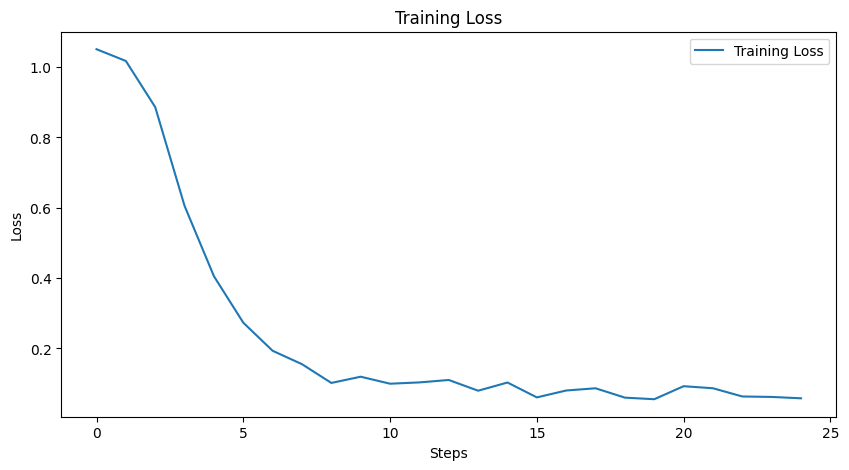

In [19]:
# Evaluate the training of the model
metrics = trainer.evaluate()
print(metrics)

model.config.save_pretrained("./backup")

log_history = trainer.state.log_history

train_loss = [log["loss"] for log in log_history if "loss" in log]
print(train_loss)
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

Evaluation of the fine-tuned model:

In [26]:
# Load fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2ForSequenceClassification.from_pretrained("reward_modeling", num_labels=1)
model = model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
def get_logits(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.squeeze().item()
    return logits

In [38]:
text=train_str['chosen'][0]
logits = get_logits(text=text)
print(f"### Chosen Text:{text}\n\n\n### Score: {logits}\n")
print("-"*50)

text=train_str['rejected'][0]
logits = get_logits(text=text)
print(f"### Rejected Text:{text}\n\n\n### Score: {logits}\n")
print("-"*50)

### Chosen Text:

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.


### 

In [45]:
import random

correct = 0
total = 0

for i in range(len(train_str['chosen'])):
    chosen = train_str['chosen'][i]
    rejected = train_str['rejected'][i]

    logits_chosen = get_logits(text=chosen)
    logits_rejected = get_logits(text=rejected)

    if logits_chosen > logits_rejected:
        correct += 1
    else:
        if random.random() < 0.1 and abs(logits_chosen-logits_rejected)>5: #Print 10% of misclassified responses
            print(f"### Chosen Text:{chosen}\n\n\n### Score: {logits_chosen}\n")
            print(f"### Rejected Text:{rejected}\n\n\n### Score: {logits_rejected}\n")
    total += 1

### Chosen Text:

Human: Can you help me find a good summer internship.

Assistant: Sure, finding a good summer internship can be a great way to gain useful experience. What type of internship are you looking for? What kind of skills and experience do you have.


### Score: 0.9657723903656006

### Rejected Text:

Human: Can you help me find a good summer internship.

Assistant: Search online for a variety of terms related to how much money you’d be able to make while working as a summer intern.

2. Search for a list of employers that have a summer internship, and send out your resume to these employers.

3. Consider other ways to get money while working as a summer intern.


### Score: 6.298035144805908

### Chosen Text:

Human: Can you recommend me resources on starting an e-commerce business.

Assistant: Yes, I can recommend the following resources on starting an e-commerce business: 
1. The Small Business Administration’s guide to E-commerce: https://www.sba.gov/business-guide/launc

In [46]:
print(f"Accuracy: {correct / total * 100:.2f}%")

Accuracy: 97.79%
